# Text Emotion Classification

The goal of this project is to build an AI model that can accurately classify text based on emotion.
I'm using a [dataset](https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data) of over 10,000 labeled personal tweets to train my model.

Some key insights I want to explore include:
* What are the common words used across different sentiments?
* The differences between using a probabilistic model like Naive Bayes vs. using an RNN.

## Accessing the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
emotions_df = pd.read_csv('./dataset/training.csv')
emotions_df.head()
emotions_df.columns

Index(['text', 'label'], dtype='object')

In [3]:
# a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4).

emotions_with_labels = emotions_df.copy()
emotions_with_labels['label'] = emotions_with_labels['label'].replace({0:'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5:'surprise'})


<Axes: xlabel='label'>

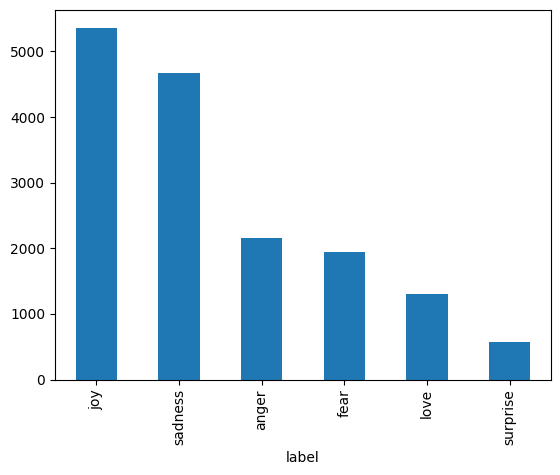

In [4]:
# this tells me that the dataset is kinda balanced and it'll be good for distinguishing joy and sadness

emotions_with_labels.value_counts('label')
emotions_with_labels['label'].value_counts().plot(kind='bar')

In [5]:
emotions_with_labels[emotions_with_labels['label'] == 'love'].head()
emotions_with_labels.isna().sum()
# emotions_with_labels.iloc[14].text

text     0
label    0
dtype: int64

## Preprocessing

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)         # remove punctuation
    text = re.sub(r'\d+', '', text)             # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # remove stopwords
    return text

In [8]:
emotions_with_labels['text'] = emotions_with_labels['text'].apply(preprocess)
emotions_with_labels['text'] = emotions_with_labels['text'].apply(word_tokenize)

In [9]:
emotions_with_labels['text'].head()

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
Name: text, dtype: object

## Wordcloud

In [10]:
from wordcloud import WordCloud

def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(text) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

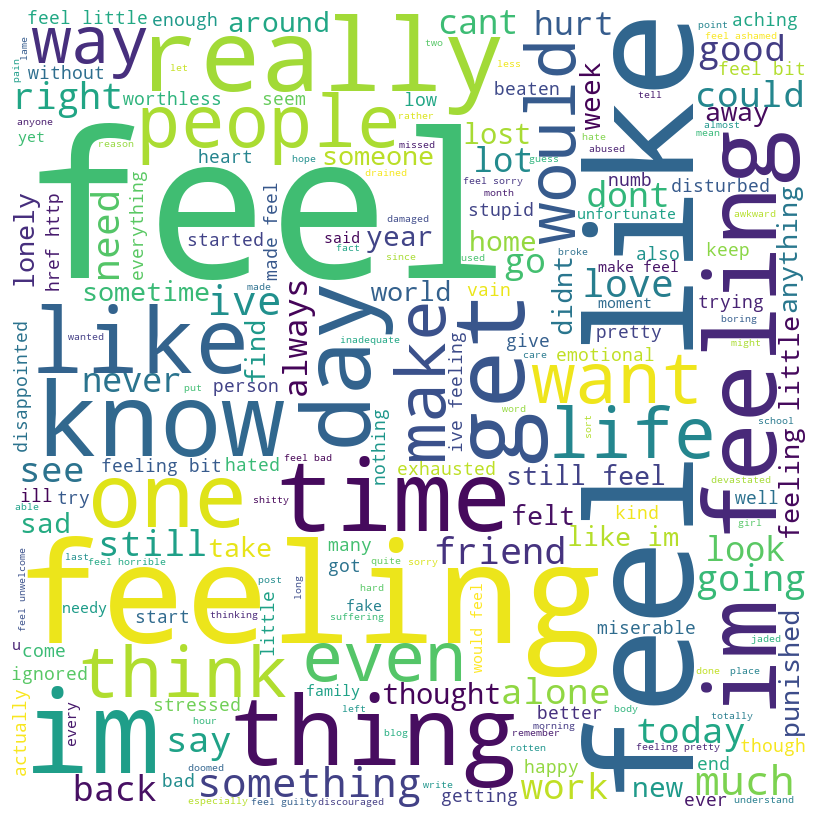

In [11]:
# emotions_with_labels[emotions_with_labels['label'] == 'joy']['text']
word_cloud = emotions_with_labels[emotions_with_labels['label'] == 'sadness']['text']
word_cloud = word_cloud.dropna().apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))  # Convert lists to strings
plot_wordcloud(" ".join(word_cloud))

## Making the Model - Multinomial Naive Bayes

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# splitting data
X = emotions_with_labels['text'].astype(str)  # Ensure text is string type
y = emotions_with_labels['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=7500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# encode labels if needed
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# train model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [13]:
y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6872


## Evaluating Model

              precision    recall  f1-score   support

       anger       0.91      0.38      0.54       427
        fear       0.91      0.30      0.46       397
         joy       0.62      0.98      0.76      1021
        love       1.00      0.06      0.11       296
     sadness       0.71      0.94      0.81       946
    surprise       1.00      0.01      0.02       113

    accuracy                           0.69      3200
   macro avg       0.86      0.45      0.45      3200
weighted avg       0.77      0.69      0.62      3200



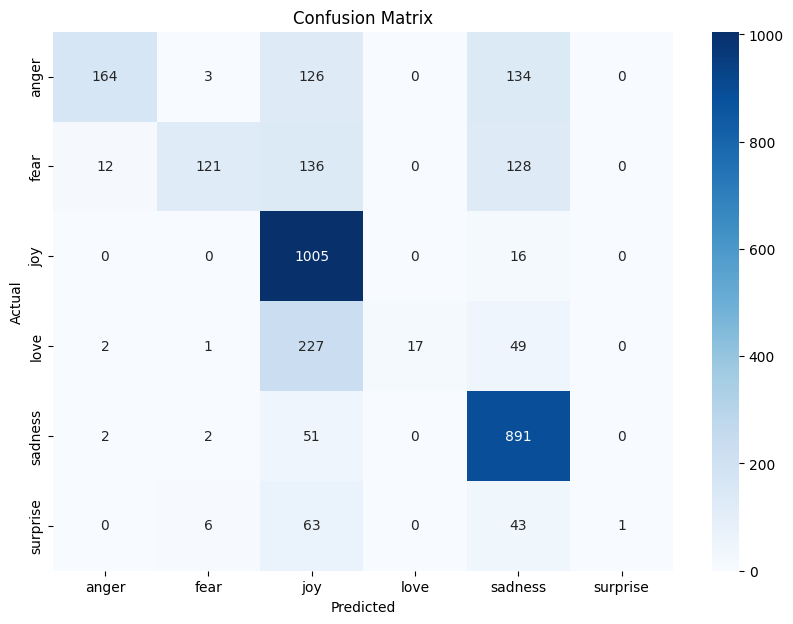

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# testing the model for fun lol
def predict_emotion(text):
    text = preprocess(text)
    text = " ".join(word_tokenize(text))
    sample_text_tfidf = tfidf.transform([text])

    probs = nb.predict_proba(sample_text_tfidf)[0]  # returns an array of probabilities
    pred = nb.predict(sample_text_tfidf)[0]
    predicted_label = le.inverse_transform([pred])[0]
    class_probs = dict(zip(le.classes_, probs))
    
    return predicted_label, class_probs

In [16]:
label, probabilities = predict_emotion("the way that he ran at me was scary")
print("Predicted Label:", label)

for emotion, prob in probabilities.items():
    print(f'{emotion} - {prob}')

Predicted Label: joy
anger - 0.12970838717403493
fear - 0.1694004362574818
joy - 0.36401447362438855
love - 0.05394956872582229
sadness - 0.25554754475147234
surprise - 0.027379589466799817


## Insights

By using Multinomial Naive Bayes, we observe that the model performs well in identifying 'Joy' and 'Sadness' but struggles to distinguish other emotions.

This is partly due to the influence of prior probabilities in Naive Bayes.

Since our training data is predominantly labeled as 'Joy' and 'Sadness', their prior probabilities are around 40%.

As a result, the model is biased toward these emotions, making it more likely to classify text as 'Joy' or 'Sadness' rather than less frequent emotions like 'Fear' or 'Anger'.

It's also important to note that the order of words does not matter in Naive Bayes, as it assumes all events are independent (conditional independence).

## Making the Model - Recurrent Neural Network

In [ ]:
# TODO - make model with tensorflow
